# Exploratory Data Analysis Exercise Reference

## 對環保署各測站的 PM2.5 資料進行主成分分析

首先，匯入需要使用的函式庫，然後讀取 `../data/pm25_2015.csv` 以進行分析。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pm25 = pd.read_csv('../data/pm25_2015.csv')     # Read in the data
print(pm25.shape)                               # Print out the data dimension
print(pm25.keys())

(8760, 78)
Index(['date', 'hour', '二林', '南投', '埔里', '大里', '彰化', '忠明', '沙鹿', '竹山', '線西',
       '西屯', '豐原', '三重', '中壢', '中山', '古亭', '土城', '基隆', '士林', '大同', '大園', '平鎮',
       '新店', '新莊', '松山', '板橋', '林口', '桃園', '永和', '汐止', '淡水', '菜寮', '萬華', '萬里',
       '觀音', '陽明', '龍潭', '冬山', '宜蘭', '三義', '新竹', '湖口', '竹東', '苗栗', '頭份', '臺東',
       '花蓮', '關山', '金門', '馬公', '馬祖', '善化', '嘉義', '安南', '崙背', '斗六', '新港', '新營',
       '朴子', '臺南', '臺西', '麥寮', '仁武', '前金', '前鎮', '大寮', '小港', '屏東', '左營', '復興',
       '恆春', '林園', '楠梓', '橋頭', '潮州', '美濃', '鳳山'],
      dtype='object')


我們有76個測站的 PM2.5 逐時的資料。讓我們看看每個測站有多少的遺失值：

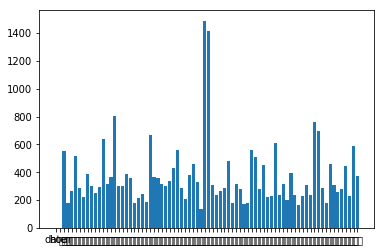

In [2]:
nancounts = pm25.apply(lambda x: len(x)-x.count())      # Number of NaN is the 
plt.bar(nancounts.keys(), nancounts)
plt.show()

由於70多個測站直接看數字並不容易閱讀，我們可以先用圖形呈現，然後再聚焦看看遺失值比較多的測站。

In [3]:
print("Stations with more than 1000 missing values:")
print(nancounts[nancounts>1000])
print()
print("Stations with more than 500 missing values:")
print(nancounts[nancounts>500])

Stations with more than 1000 missing values:
冬山    1489
宜蘭    1414
dtype: int64

Stations with more than 500 missing values:
二林     552
大里     515
豐原     640
中山     804
新莊     667
淡水     558
冬山    1489
宜蘭    1414
馬公     561
馬祖     512
斗六     609
大寮     758
小港     698
美濃     585
dtype: int64


## 遺失值處理：拋棄遺失值

由於資料包含了大量的遺失值，所以我們需要進一步處理。最簡單的處理方式，是拋棄任何一個測站有遺失值的觀測時間，我們可以使用[`pandas.DataFrame.dropna()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) 函數，來保留完整的觀測。

In [4]:
pm25_dropna = pm25.dropna()
print(pm25_dropna.shape)

nanc_dropna = pm25_dropna.apply(lambda x: len(x)-x.count())
nanc_dropna[nanc_dropna>0]

(1195, 78)


Series([], dtype: int64)

排除有遺失值的資料之後，我們只剩下 1195 筆完整的觀測，我們可以先試試看用這組資料做 PCA 的結果。

Accumulative Ratio of Variance Explained by PCs:
[0.651377 0.774502 0.824736 0.844623 0.860774 0.873928 0.883919 0.893242
 0.89996  0.906018 0.91116  0.915994 0.920304 0.924438 0.928144 0.93168
 0.934645 0.937505 0.940247 0.942903]


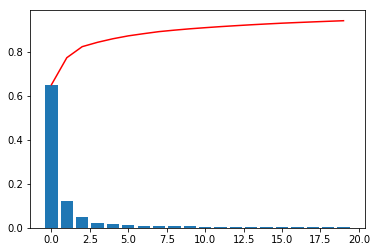

In [5]:
pca_dropna = PCA(n_components=20)
pca_dropna.fit(pm25_dropna.iloc[:,2:])

print('Accumulative Ratio of Variance Explained by PCs:')
print(np.round(np.cumsum(pca_dropna.explained_variance_ratio_), 6))

plt.bar(range(20),pca_dropna.explained_variance_ratio_)
plt.plot(np.cumsum(pca_dropna.explained_variance_ratio_), 'r-')
plt.show()

從結果看來，前10個 PC 可以解釋 90% 以上的變異，但是由於直接丟棄遺失值之後，資料的觀測時間並不是連續的，在後續的詮釋上可能會有問題，因此我們可能需要採取其他的遺失值處理策略。


## 遺失值處理：內插

處理遺失值的另一個選擇是把缺的數值補上（[data imputation](https://en.wikipedia.org/wiki/Imputation_(statistics))），[`pandas.DataFrame.interpolate()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate) 函數提供了多種內插函數。

預設的內插方式是線性內插，其他還有許多內插方式，例如： `pandas.DataFrame.interpolate(method='polynomial', order=3)`  是三階多項式內插。

In [6]:
pm25_itpl = pm25.interpolate(method='polynomial', order=3)
print(pm25_itpl.shape)

nanc_itpl = pm25_itpl.apply(lambda x: len(x)-x.count())
nanc_itpl[nanc_itpl>0]

(8760, 78)


板橋    160
dtype: int64

內插完之後，我們發現板橋站還是有160個遺失值，觀察原始資料，原來是從第一筆資料開始缺，所以沒辦法「內插」。我們可以用[`pandas.DataFrame.dropna(axis='columns')`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) 來排除板橋站的資料。

In [7]:
pm25_itpl = pm25_itpl.dropna(axis='columns')
print(pm25_itpl.shape)

nanc_itpl = pm25_itpl.apply(lambda x: len(x)-x.count())
nanc_itpl[nanc_itpl>0]

(8760, 77)


Series([], dtype: int64)

檢查排除板橋測站之後的資料數量是正確的，那麼我們再以新的資料來做 PCA：

Accumulative Ratio of Variance Explained by PCs:
[0.609753 0.75546  0.825869 0.852726 0.874277 0.893159 0.905097 0.914755
 0.923025 0.930556 0.93639  0.941075 0.94503  0.9485   0.951699 0.954629
 0.957396 0.960137 0.962218 0.964136]


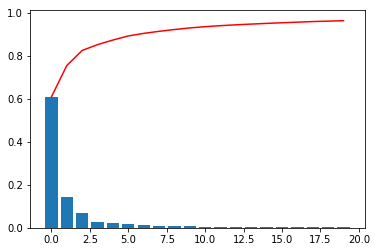

In [8]:
pca_itpl = PCA(n_components=20)
pca_itpl.fit(pm25_itpl.iloc[:,2:])

print('Accumulative Ratio of Variance Explained by PCs:')
print(np.round(np.cumsum(pca_itpl.explained_variance_ratio_), 6))

plt.bar(range(20),pca_itpl.explained_variance_ratio_)
plt.plot(np.cumsum(pca_itpl.explained_variance_ratio_), 'r-')
plt.show()

Imputation 之後的 PCA 結果，前 7 個主成分就可以解釋 90% 的資料變異，接下來我們可以看看前兩個 PC 的長相：

### PC1

(20, 75)


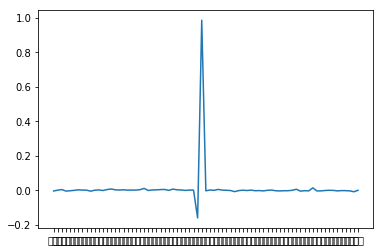

In [9]:
pcs = pd.DataFrame(pca_itpl.components_, columns=pm25_itpl.keys()[2:])
print(pca_itpl.components_.shape)
plt.plot(pcs.iloc[0])
plt.show()

In [10]:
print(pcs.iloc[0].sort_values(ascending=False).head())
print(pcs.iloc[0].sort_values(ascending=True).head())

宜蘭    0.986685
大寮    0.014866
新莊    0.011865
古亭    0.008409
菜寮    0.007761
Name: 0, dtype: float64
冬山   -0.159234
美濃   -0.007604
花蓮   -0.006827
西屯   -0.004206
仁武   -0.004017
Name: 0, dtype: float64


第一主成分看起來是一個「在宜蘭有極大值，在冬山有極小值」的空間分布。我們可以思考一下，這樣的空間分布有什麼特別的物理意義。

### PC2

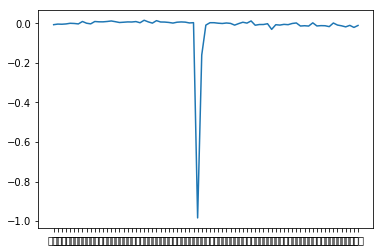

新莊    0.015842
桃園    0.013787
馬祖    0.012258
古亭    0.012182
中山    0.009557
Name: 1, dtype: float64
冬山   -0.984170
宜蘭   -0.160151
斗六   -0.030278
美濃   -0.020473
橋頭   -0.017677
Name: 1, dtype: float64


In [11]:
plt.plot(pcs.iloc[1])
plt.show()
print(pcs.iloc[1].sort_values(ascending=False).head())
print(pcs.iloc[1].sort_values(ascending=True).head())

第二主成分是個「在冬山和宜蘭有極值」的空間分布。


## 在地圖上呈現 PC

接下來，我們想把這個空間分布畫在地圖上，方便我們理解。首先，我們讀取測站的經緯度資料，然後跟分析出來的主成分合併成一個資料集。

In [12]:
stations = pd.read_csv('../data/epa_stations.csv')  # Read in the data
staloc = stations.loc[:,['測站名稱','經度','緯度']]  # Retrieve only relevant information.
print(staloc.shape)
print(staloc.head())

(79, 3)
  測站名稱          經度         緯度
0   士林  121.514500  25.105917
1   萬華  121.507972  25.046503
2   大同  121.513311  25.063200
3   中山  121.526528  25.062361
4   古亭  121.529556  25.020608


In [13]:
pc1loc = pd.merge(staloc, pd.DataFrame(pcs.iloc[0]), left_on='測站名稱', right_index=True)
pc1loc.head()

,測站名稱,經度,緯度,0
0,士林,121.514500,25.105917,0.003810
1,萬華,121.507972,25.046503,0.003818
2,大同,121.513311,25.063200,0.001607
3,中山,121.526528,25.062361,0.005353
4,古亭,121.529556,25.020608,0.008409


合併完成之後，我們要把測站資料透過平面內插，製作成網格資料。

In [14]:
import os
os.environ['PROJ_LIB'] = '/Users/tsyo/anaconda/share/proj/'
#os.environ['PROJ_LIB'] = 'C:\\usr\\Anaconda3\\Library\\share\\'
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
# First we define the 4 corners of the grid space
x1tw = 118.
x2tw = 124.
y1tw = 20.5
y2tw = 26.5
# And then we create the grid space
xtw = np.linspace(x1tw,x2tw,30)
ytw = np.linspace(y1tw,y2tw,30)
Xtw, Ytw = np.meshgrid(xtw,ytw)
# Retrieve the station location and values
lons =pc1loc['經度']
lats = pc1loc['緯度']
pm25sta = pc1loc[0]
print(pm25sta.head())
pm25grid = griddata((lons, lats), pm25sta, (Xtw, Ytw), method='linear')

0    0.003810
1    0.003818
2    0.001607
3    0.005353
4    0.008409
Name: 0, dtype: float64


然後，我們把主成分畫在地圖上：

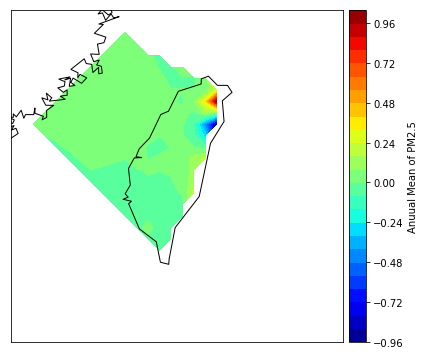

In [15]:
fig = plt.figure(figsize=(6,6))                     # Define the figure size
m = Basemap(llcrnrlon=118., urcrnrlon=124., llcrnrlat=20.5, urcrnrlat=26.5, resolution='l') # Make a map of East Asia
m.contourf(Xtw, Ytw, pm25grid, 30, cmap=plt.cm.jet) # Draw a filled-contour plot with the interpolated grid data
m.drawcoastlines()                                  # Draw the coastlines
cb = m.colorbar()                                   # Show colorbar
cb.set_label('Anuual Mean of PM2.5')                # Add colobar title
plt.tight_layout()
plt.show()

我們可以對第二主成分做一樣的處理：

(75, 4)
  測站名稱          經度         緯度         0
0   士林  121.514500  25.105917  0.003810
1   萬華  121.507972  25.046503  0.003818
2   大同  121.513311  25.063200  0.001607
3   中山  121.526528  25.062361  0.005353
4   古亭  121.529556  25.020608  0.008409


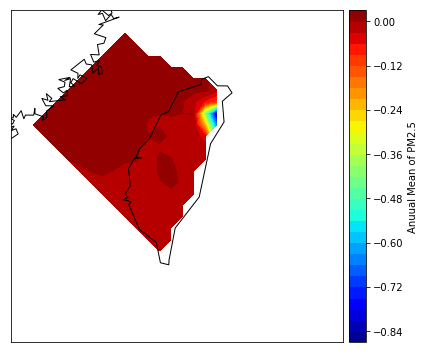

In [16]:
# Making PC2 data with lon/lat
pc2loc = pd.merge(staloc, pd.DataFrame(pcs.iloc[1]), left_on='測站名稱', right_index=True)
print(pc1loc.shape)
print(pc1loc.head())
# Retrieve the station location and values
lons =pc2loc['經度']
lats = pc2loc['緯度']
pm25sta_pc2 = pc2loc.iloc[:,3]
pm25grid_pc2 = griddata((lons, lats), pm25sta_pc2, (Xtw, Ytw), method='linear', rescale=True)
# Making plot
fig = plt.figure(figsize=(6,6))                     # Define the figure size
m = Basemap(llcrnrlon=118., urcrnrlon=124., llcrnrlat=20.5, urcrnrlat=26.5, resolution='l') # Make a map of East Asia
m.contourf(Xtw, Ytw, pm25grid_pc2, 30, cmap=plt.cm.jet) # Draw a filled-contour plot with the interpolated grid data
m.drawcoastlines()                                  # Draw the coastlines
cb = m.colorbar()                                   # Show colorbar
cb.set_label('Anuual Mean of PM2.5')                # Add colobar title
plt.tight_layout()
plt.show()

## 初步分析

從前面的結果看來，我們選擇「三階多項式內插」作為 imputation 的方法似乎不是很恰當，因為在地圖上的呈現結果與之前繪製過的「年均 PM2.5 濃度」似乎有很大的差距，而一般來說，第一主成分應該會跟平均狀態有相似的分布（量值不一定一致，但 pattern 應該是相似或反向）。

<img src='figures/mean_pm25_2015.png' />

作為比較，我們來看看直接排除遺失值的 PCA 結果。由於我們會反覆用到「由測站轉換到網格」和「繪圖」的功能，我們可以先把這個部分寫成函數。

In [17]:
def plot_pcs_on_map(staloc, pcs, ll_lon=118., ur_lon=124., ll_lat=20.5, ur_lat=26.5, nx=30, ny=30, npc=1):
    # Create the grid space for mapping
    x = np.linspace(ll_lon,ur_lon,nx)
    y =  np.linspace(ll_lat,ur_lat,ny)
    X, Y = np.meshgrid(x,y)
    # Plot PCs as specified
    for i in range(npc):
        # Create merged station data
        pcloc = pd.merge(staloc, pd.DataFrame(pcs.iloc[i]), left_on='測站名稱', right_index=True)
        # Convevrt station data to grid data
        gdata = griddata((pcloc['經度'], pcloc['緯度']), pcloc.iloc[:,3], (X, Y), method='linear')
        # Make plot
        fig = plt.figure(figsize=(6,6))                     # Define the figure size
        m = Basemap(llcrnrlon=ll_lon, urcrnrlon=ur_lon, llcrnrlat=ll_lat, urcrnrlat=ur_lat, resolution='l')
        m.contourf(X, Y, gdata, 30, cmap=plt.cm.jet)        # Draw a filled-contour plot with the interpolated grid data
        m.drawcoastlines()                                  # Draw the coastlines
        cb = m.colorbar()                                   # Show colorbar
        plt.title('PC' + str(i+1))
        plt.tight_layout()
        plt.show()
    # Done
    return(0)

然後，我們講兩種遺失值處理方式的 PCA 結果畫在地圖上：

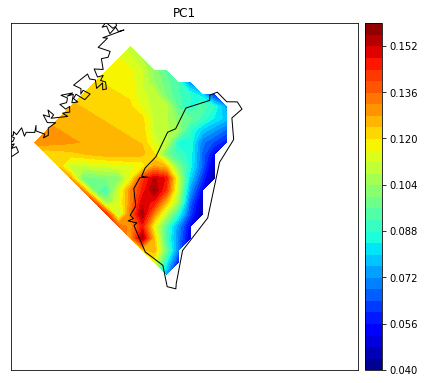

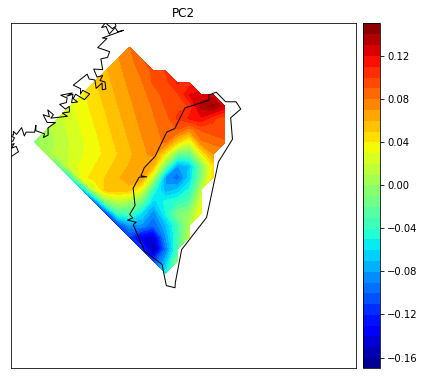

0

In [18]:
pcs = pd.DataFrame(pca_dropna.components_, columns=pm25_dropna.keys()[2:])
plot_pcs_on_map(staloc, pcs, npc=2)

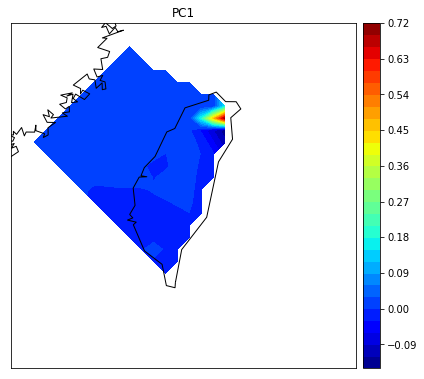

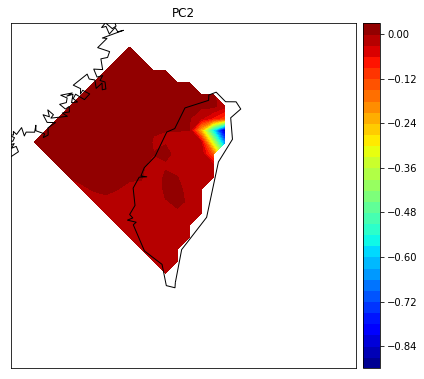

0

In [19]:
pcs = pd.DataFrame(pca_itpl.components_, columns=pm25_itpl.keys()[2:])
plot_pcs_on_map(staloc, pcs, npc=2)

跟年平均值比較，第一種遺失值處理的方式（直接排除有遺失值的資料）看起來比較合理，因此我們之前使用「三階多項式」的內插方法，似乎不盡理想。我們應該改用其他的內插方式，重新來做 imputation。

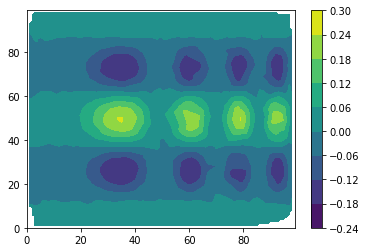

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.interpolate import griddata

def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])
grid_z2 = griddata(points, values, (grid_x, grid_y), method='linear')

plt.contourf(grid_z2)
plt.colorbar()
plt.show()